In [1]:
import matplotlib.pyplot as plt
import time
import torch
from torch import logsumexp
from torch.distributions.normal import Normal
import numpy as np
from utils_v1 import *
from plots import *
from objectives_v1 import *

In [2]:
## training parameters
STEPS = 5000
DATA_DIM= 50
NUM_SAMPLES = 256
NUM_SAMPLES_SNR = 100
LEARNING_RATE = 1e-2
## model parameters
# p_mu = torch.tensor([0.0])
# p_sigma = torch.tensor([1.0])
# q_mu = torch.tensor([8.0], requires_grad=True)
# q_sigma = torch.tensor([2.0], requires_grad=True) 
## initialize optimizer
# optimizer = torch.optim.Adam([q_mu, q_sigma], lr=LEARNING_RATE)
## estimators
ests = ['mc', 'iwae', 'iwae-dreg', 'rws', 'rws-dreg']

In [3]:
dLOSSs = dict()
# dEUBOs = dict()
# dELBOs = dict()
# dIWELBOs = dict()
# dSNRs = dict()
# dVARs = dict()
dESSs = dict()
dKLs = dict()
print('======= start training ========\n')
for est in ests:
    ## model parameters
    p_mu = torch.zeros(DATA_DIM)
    p_sigma = torch.ones(DATA_DIM)
    q_mu = torch.ones(DATA_DIM) * 8.0
    q_mu.requires_grad = True
    q_sigma = torch.ones(DATA_DIM) * 1.0
    q_sigma.requires_grad = True
    ## initialize optimizer
    optimizer = torch.optim.Adam([q_mu, q_sigma], lr=LEARNING_RATE)
    time_start = time.time()
    if est == 'mc':
        LOSSs, EUBOs, ELBOs, IWELBOs, ESSs, SNRs, VARs, KLs = train(mc, q_mu, q_sigma, p_mu, p_sigma, STEPS, NUM_SAMPLES, optimizer, filename=est, num_batches=None)        
    elif est == 'iwae':
        LOSSs, EUBOs, ELBOs, IWELBOs, ESSs, SNRs, VARs, KLs = train(iwae, q_mu, q_sigma, p_mu, p_sigma, STEPS, NUM_SAMPLES, optimizer, filename=est, num_batches=None)        
    elif est == 'iwae-dreg':
        LOSSs, EUBOs, ELBOs, IWELBOs, ESSs, SNRs, VARs, KLs = train(driwae, q_mu, q_sigma, p_mu, p_sigma, STEPS, NUM_SAMPLES, optimizer, filename=est, num_batches=None)        
    elif est == 'rws':
        LOSSs, EUBOs, ELBOs, IWELBOs, ESSs, SNRs, VARs, KLs = train(rws, q_mu, q_sigma, p_mu, p_sigma, STEPS, NUM_SAMPLES, optimizer, filename=est, num_batches=None)      
    elif est == 'rws-dreg':
        LOSSs, EUBOs, ELBOs, IWELBOs, ESSs, SNRs, VARs, KLs = train(drrws, q_mu, q_sigma, p_mu, p_sigma, STEPS, NUM_SAMPLES, optimizer, filename=est, num_batches=None)           
    
#     dEUBOs[est] = EUBOs
#     dELBOs[est] = ELBOs
#     dIWELBOs[est] = IWELBOs
#     dSNRs[est] = SNRs
#     dVARs[est] = VARs
    dLOSSs[est] = np.array(LOSSs)
    dESSs[est] = ESSs
    dKLs[est] = KLs
    time_end = time.time()
    print('%s training completed.. (%ds)' % (est, time_end - time_start))

======= start training ========

mc training completed.. (9s)
iwae training completed.. (10s)
iwae-dreg training completed.. (7s)
rws training completed.. (9s)
rws-dreg training completed.. (8s)


In [13]:
def plot_results_simplified(dLOSSs, dESSs, dKLs, data_dim, num_samples, lr, ests, fs=20):
    fig = plt.figure(figsize=(fs,fs))
    colors = {'mc':'green', 'iwae': 'red', 'iwae-dreg': 'blue', 
              'rws': 'deepskyblue', 'rws-dreg': 'firebrick', 'stl': 'black'}
    fig = plt.figure(figsize=(fs,fs))
    ax = fig.subplots(3, 1, gridspec_kw={'wspace':0.1, 'hspace':0.1})
    
    for i, est in enumerate(ests):
        LOSSs = dLOSSs[est]
        ESSs = dESSs[est]
        KLs = dKLs[est]
        if est == 'mc' or est == 'iwae' or est == 'iwae-dreg':
            ax[0].plot(- LOSSs, c=colors[est], label= 'ELBO' + est)
            ax[1].plot(KLs, c=colors[est], label=est)
            ax[2].plot(np.array(ESSs), c=colors[est], label=est)                 
        elif est =='rws' or est == 'rws-dreg':
            ax[0].plot(LOSSs, c=colors[est], label= 'EUBO' + est)
            ax[1].plot(KLs, c=colors[est], label=est)
            ax[2].plot(np.array(ESSs), c=colors[est], label=est)    
    ax[0].set_title('Objectives')
    ax[1].set_title('exclusive KL')
    ax[2].set_title('ESS')
    
    for i in range(3):
        ax[i].legend(fontsize=16)
        ax[i].tick_params(labelsize=16)
        if i == 1:
            ax[i].set_yscale('log')
    plt.savefig('results/%ddim-%dsamples-%.4flr.svg' % (data_dim, num_samples, lr))

<Figure size 1440x1440 with 0 Axes>

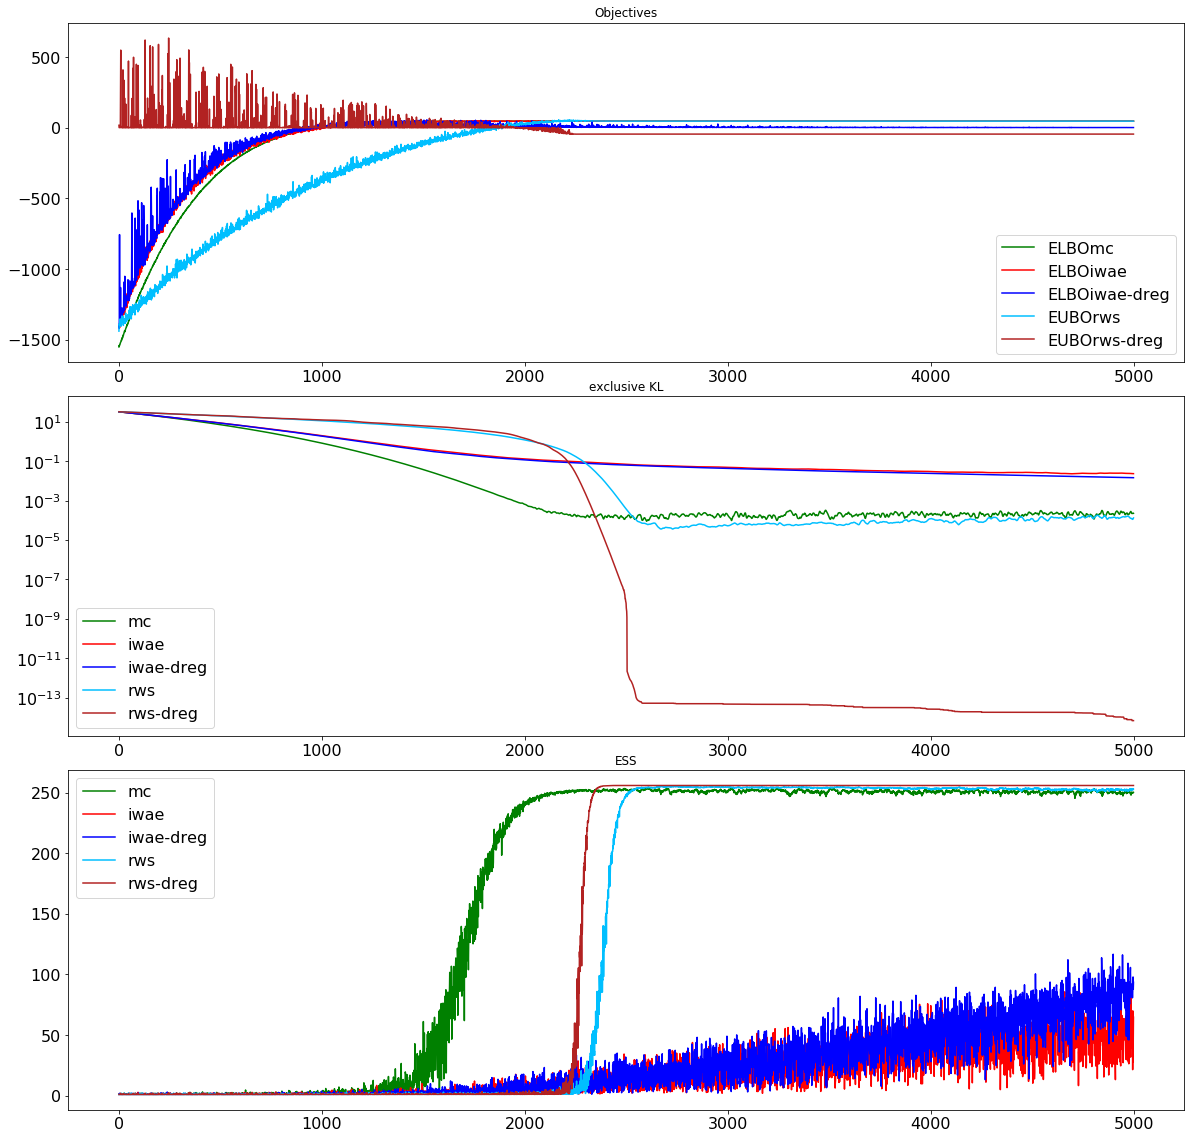

In [14]:
plot_results_simplified(dLOSSs, dESSs, dKLs, DATA_DIM, NUM_SAMPLES, LEARNING_RATE, ests)